In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D, Conv2DTranspose
from tensorflow.keras import Input, Model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
train_file = './train.csv'
test_file = './test.csv'

In [4]:
test_df = pd.read_csv(test_file)

In [5]:
df = pd.read_csv(train_file)
df.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])


In [8]:
@tf.function
def make_2d(row):
    image = tf.reshape(row, (28, 28))
    image = tf.cast(image, tf.float64)/255.
    image = tf.expand_dims(image, axis=-1)
    return image

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(train_df.drop(columns='label')).map(make_2d).shuffle(5).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices(val_df.drop(columns='label')).map(make_2d).batch(1)

In [10]:

def ssim(input_img, output_img):
    return 1 - tf.reduce_mean(tf.image.ssim(input_img, tf.cast(output_img, tf.float64), max_val=1))

In [11]:
encoder=Sequential(name='encoder')
decoder=Sequential(name='decoder')
encoder.add(Conv2D(32, 3, strides=2, activation='relu', padding='same'))
encoder.add(Conv2D(64, 3, strides=2, activation='relu', padding='same'))
encoder.add(Conv2D(128, 3, strides=2, activation='relu'))
decoder.add(Conv2DTranspose(64, 3, strides=2, activation='relu'))
decoder.add(Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(1, 3, strides=2, activation='relu', padding='same'))

In [12]:
autoencoder=Sequential([encoder, decoder],name='autoencoder')
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Epoch 1: loss: 0.08426630485625494
Epoch 2: loss: 0.01631821967306591
Epoch 3: loss: 0.011740501040504092
Epoch 4: loss: 0.00939438263575236
Epoch 5: loss: 0.007841804879052299


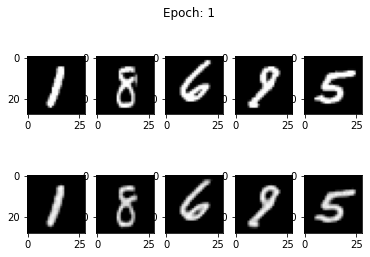

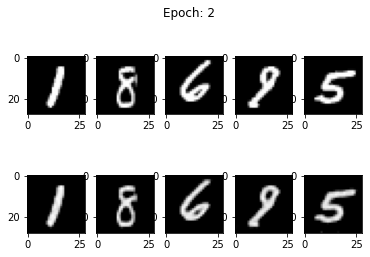

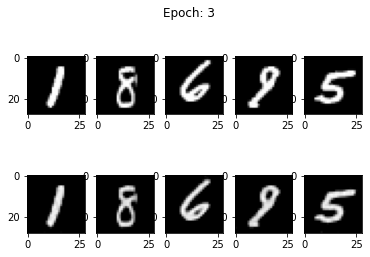

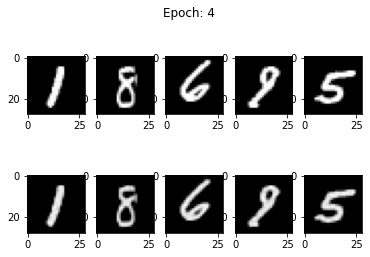

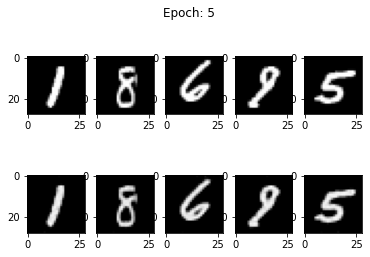

In [13]:
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    for step, (image) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            output = autoencoder(image, training=True)
            loss = ssim(image, output)
        grads = tape.gradient(loss, autoencoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
        total_loss += loss.numpy()
    print(f"Epoch {epoch+1}: loss: {total_loss/(step+1)}")

    fig, ax = plt.subplots(2, 5)
    for step, (image) in enumerate(val_ds.take(5)):
        output = autoencoder(image, training=False)
        loss = ssim(image, output)
        ax[0][step].imshow(image.numpy()[0], cmap="gray")
        ax[1][step].imshow(output.numpy()[0], cmap="gray")
        fig.suptitle(f"Epoch: {epoch+1}")

In [14]:
autoencoder.save_weights('anomaly_autoencoder.h5')

In [14]:
all_loss = []
for step, (image) in enumerate(val_ds):
    output = autoencoder(image, training=False)
    loss = ssim(image, output)
#    wandb.log({"val_loss_for_threshold": loss.numpy()})
    all_loss.append(loss.numpy())

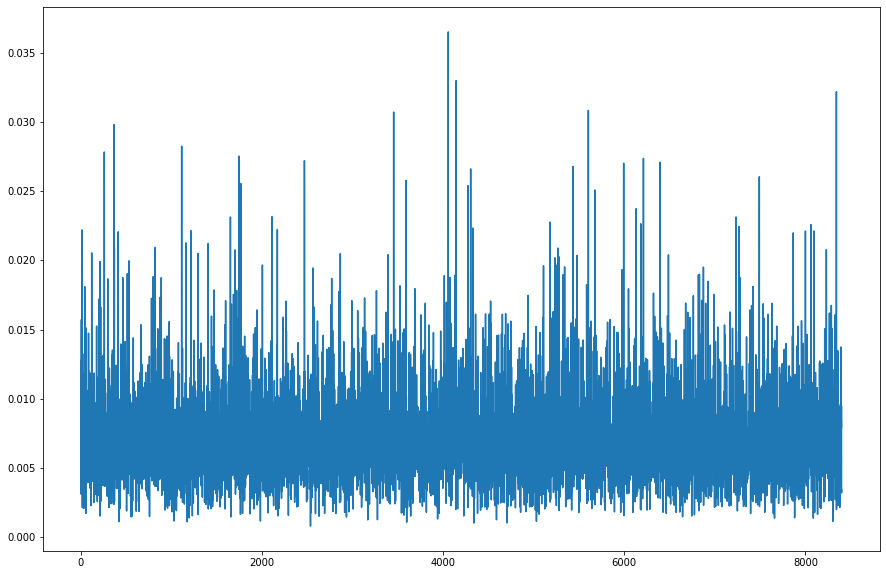

In [15]:
plt.figure(figsize=(15,10))
plt.plot(range(1, len(all_loss)+1), all_loss);



In [16]:
_99th_percentile = np.percentile(all_loss,q=99)
print(_99th_percentile)

0.017821068167686468


In [17]:


THRESH_LOSS = _99th_percentile

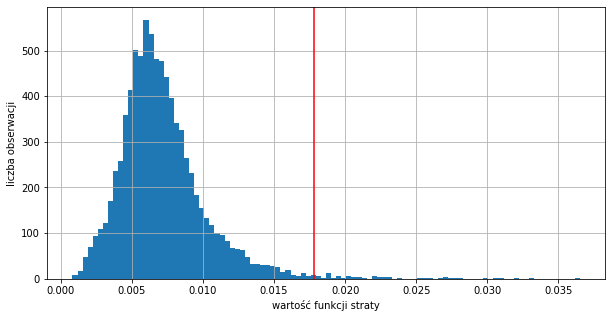

In [32]:
plt.figure(figsize=(10,5))
plt.hist(all_loss, bins=100)
plt.xlabel("wartość funkcji straty")
plt.ylabel("liczba obserwacji")
plt.axvline(THRESH_LOSS, color='red')
plt.grid(True)
plt.show()

In [19]:
test_ds = tf.data.Dataset.from_tensor_slices(test_df.values).map(make_2d).batch(1)

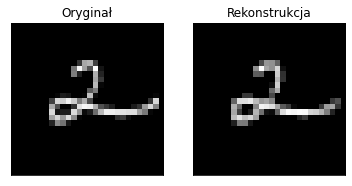

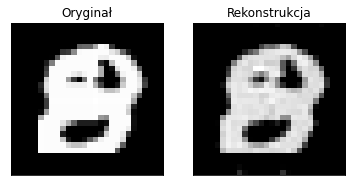

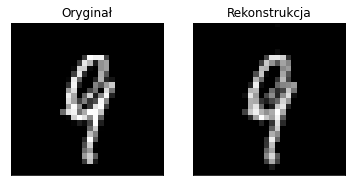

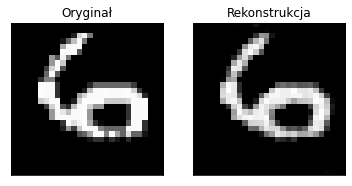

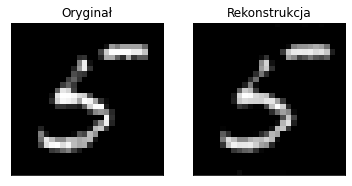

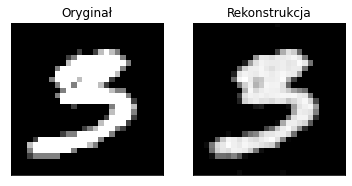

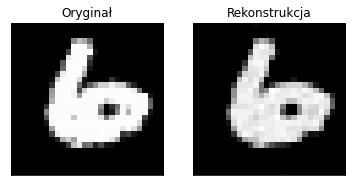

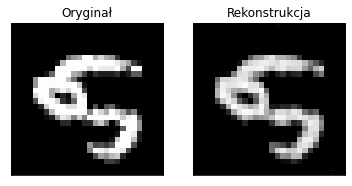

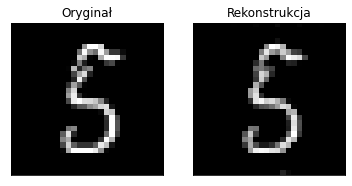

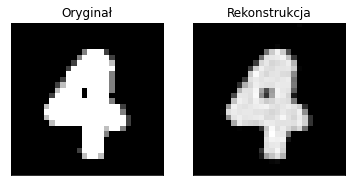

In [22]:
outliers = []
extreme_outliers = []
all_loss = []
i=0
for image in test_ds:
    output = autoencoder(image, training=False)
    loss = ssim(image, output)
    all_loss.append(loss.numpy())
   # wandb.log({"test_loss":loss.numpy()})
    if loss.numpy() > THRESH_LOSS and i<10:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(image.numpy()[0], cmap="gray")
        ax[0].title.set_text("Oryginał")
        ax[1].imshow(output.numpy()[0], cmap="gray")
        ax[1].title.set_text("Rekonstrukcja")
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)
        ax[1].get_xaxis().set_visible(False)
        i=i+1
    if i==10:
        break

In [24]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         73792     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                                 
Total params: 92,545
Trainable params: 92,545
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (32, 14, 14, 32)          320       
                                                                 
 conv2d_4 (Conv2D)           (32, 7, 7, 64)            18496     
                                                                 
 conv2d_5 (Conv2D)           (32, 3, 3, 128)           73856     
                                                                 
Total params: 92,672
Trainable params: 92,672
Non-trainable params: 0
_________________________________________________________________
